### Load Package yang dibutuhkan

In [197]:
import pandas  as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV,StratifiedKFold 
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from xgboost import plot_importance  
import xgboost as xgb
from pathlib import Path  
import seaborn as sns
sns.set()


### Load dataset application history

In [198]:
#load credit application history data
app_history = pd.read_csv(r"D:\Project\INALYST-CREDIT SCORE\dataset\application_history.csv")
app_history.head()

,Id_customer,JK,KepemilikanMobil,KepemilikanProperti,JmlAnak,Pendapatan,TipePendapatan,TingkatPendidikan,StatusKeluarga,TipeRumah,FlagMobile,FlagWorkPhone,FlagPhone,Email,Pekerjaan,JmlAnggotaKeluarga,Age,Experience
0,5008804,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0
1,5008805,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0
2,5008806,Laki-laki,Ya,Ya,0,112500.0,Bekerja,Graduate,Menikah,Rumah pribadi,1,0,0,0,Security staff,2.0,59.0,3.0
3,5008808,Perempuan,Tidak,Ya,0,270000.0,Asosiasi komersial,Graduate,Belum Menikah,Rumah pribadi,1,0,1,1,Sales staff,1.0,52.0,8.0
4,5008809,Perempuan,Tidak,Ya,0,270000.0,Asosiasi komersial,Graduate,Belum Menikah,Rumah pribadi,1,0,1,1,Sales staff,1.0,52.0,8.0


In [199]:
len(app_history)

438456

### Lakukan identifikasi apakah ada data yang duplikat pada kolom Id_customer

In [200]:
app_history['Id_customer'].duplicated().sum()

146

terdapat 146 record yang duplikat, maka harus kita drop yang duplikat

### Drop record yang duplikat pada dataset app_history

In [201]:
#remove id_customer yang duplicate, id customer harus unique
app_history=app_history.drop_duplicates(subset='Id_customer')
len(aph)

438310

### Load dataset credit_history

In [202]:
#load credit overdue history
credit_history = pd.read_csv(r"D:\Project\INALYST-CREDIT SCORE\dataset\credit_history.csv")
credit_history.head()

,Id_customer,Overdue
0,5001711,Tidak memiliki pinjaman
1,5001711,0
2,5001711,0
3,5001711,0
4,5001712,0


### Lakukan pengecekan nilai apa saja yang ada pada kolom Overdue

In [203]:
credit_history['Overdue'].value_counts()

0                          821230
Tidak memiliki pinjaman    208755
1                           10936
5                            1677
2                             849
3                             317
4                             222
Name: Overdue, dtype: int64

pada dasarnya value 1,2,3,4,5 sama sama memiliki tunggakan / pernah menunggak

### Lakukan pengecekan data types menggunakan pd.dtypes

In [204]:
credit_history.dtypes

Id_customer     int64
Overdue        object
dtype: object

### Replace value pada kolom 'Overdue' yang 2,3,4,5 menjadi 1 karena 1-5 artinya sama saja yaitu sama-sama pernah punya history menunggak dan replace tidak memiliki pinjaman menjadi 0 sehingga seluruh value menjadi angka

In [205]:
credit_history['Overdue'].replace(['2','3','4','5'],'1',inplace=True)
credit_history['Overdue'].replace('Tidak memiliki pinjaman','0',inplace=True)

credit_history['Overdue'].value_counts()

0    1029985
1      14001
Name: Overdue, dtype: int64

In [206]:
len(credit_history)

1043986

### Remove duplicate pada tabel credit history

In [207]:
credit_history=credit_history.drop_duplicates(subset=['Id_customer'])
len(credit_history)

45785

### Merge dataset application history dan credit history

In [208]:
dataset=app_history.merge(credit_history, on='Id_customer', how='left')
len(dataset)

438310

In [209]:
dataset.head()

,Id_customer,JK,KepemilikanMobil,KepemilikanProperti,JmlAnak,Pendapatan,TipePendapatan,TingkatPendidikan,StatusKeluarga,TipeRumah,FlagMobile,FlagWorkPhone,FlagPhone,Email,Pekerjaan,JmlAnggotaKeluarga,Age,Experience,Overdue
0,5008804,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0,0
1,5008805,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0,0
2,5008806,Laki-laki,Ya,Ya,0,112500.0,Bekerja,Graduate,Menikah,Rumah pribadi,1,0,0,0,Security staff,2.0,59.0,3.0,0
3,5008808,Perempuan,Tidak,Ya,0,270000.0,Asosiasi komersial,Graduate,Belum Menikah,Rumah pribadi,1,0,1,1,Sales staff,1.0,52.0,8.0,0
4,5008809,Perempuan,Tidak,Ya,0,270000.0,Asosiasi komersial,Graduate,Belum Menikah,Rumah pribadi,1,0,1,1,Sales staff,1.0,52.0,8.0,0


In [210]:
filtered_dataset = dataset[dataset['Overdue'].isnull()]
filtered_dataset

,Id_customer,JK,KepemilikanMobil,KepemilikanProperti,JmlAnak,Pendapatan,TipePendapatan,TingkatPendidikan,StatusKeluarga,TipeRumah,FlagMobile,FlagWorkPhone,FlagPhone,Email,Pekerjaan,JmlAnggotaKeluarga,Age,Experience,Overdue
12,6153651,Laki-laki,Ya,Ya,0,270000.0,Bekerja,Postgraduate,Menikah,Rumah pribadi,1,1,1,1,Accountants,2.0,46.0,2.0,NaN
26,6153712,Perempuan,Tidak,Ya,1,112500.0,Bekerja,Graduate,Belum Menikah,Rumah pribadi,1,0,0,0,NaN,2.0,30.0,4.0,NaN
43,6153733,Laki-laki,Ya,Ya,0,112500.0,Asosiasi komersial,Graduate,Menikah,Rumah pribadi,1,0,1,0,Drivers,2.0,56.0,12.0,NaN
44,6153734,Laki-laki,Ya,Ya,0,112500.0,Asosiasi komersial,Graduate,Menikah,Rumah pribadi,1,0,1,0,Drivers,2.0,56.0,12.0,NaN
45,6153735,Laki-laki,Ya,Ya,0,112500.0,Asosiasi komersial,Graduate,Menikah,Rumah pribadi,1,0,1,0,Drivers,2.0,56.0,12.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438305,6840104,Laki-laki,Tidak,Ya,0,135000.0,Pensioner,Graduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,NaN
438306,6840222,Perempuan,Tidak,Tidak,0,103500.0,Bekerja,Graduate,Belum Menikah,Rumah pribadi,1,0,0,0,Laborers,1.0,44.0,8.0,NaN
438307,6841878,Perempuan,Tidak,Tidak,0,54000.0,Asosiasi komersial,Postgraduate,Belum Menikah,Rumah orang tua,1,1,0,0,Sales staff,1.0,22.0,1.0,NaN
438308,6842765,Perempuan,Tidak,Ya,0,72000.0,Pensioner,Graduate,Menikah,Rumah pribadi,1,0,0,0,NaN,2.0,59.0,1001.0,NaN


### Isi calon nasabah yang tidak punya history menunggak (NULL pada kolom Overdue) dengan nilai 0

In [211]:
dataset['Overdue']= dataset['Overdue'].fillna(0)
dataset['Overdue'] = dataset['Overdue'].astype('int')
dataset.head()

,Id_customer,JK,KepemilikanMobil,KepemilikanProperti,JmlAnak,Pendapatan,TipePendapatan,TingkatPendidikan,StatusKeluarga,TipeRumah,FlagMobile,FlagWorkPhone,FlagPhone,Email,Pekerjaan,JmlAnggotaKeluarga,Age,Experience,Overdue
0,5008804,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0,0
1,5008805,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0,0
2,5008806,Laki-laki,Ya,Ya,0,112500.0,Bekerja,Graduate,Menikah,Rumah pribadi,1,0,0,0,Security staff,2.0,59.0,3.0,0
3,5008808,Perempuan,Tidak,Ya,0,270000.0,Asosiasi komersial,Graduate,Belum Menikah,Rumah pribadi,1,0,1,1,Sales staff,1.0,52.0,8.0,0
4,5008809,Perempuan,Tidak,Ya,0,270000.0,Asosiasi komersial,Graduate,Belum Menikah,Rumah pribadi,1,0,1,1,Sales staff,1.0,52.0,8.0,0


In [212]:
#cek data fitur ada yang null apa engga
dataset.isnull().sum()

Id_customer                 0
JK                          0
KepemilikanMobil            0
KepemilikanProperti         0
JmlAnak                     0
Pendapatan                  0
TipePendapatan              0
TingkatPendidikan           0
StatusKeluarga              0
TipeRumah                   0
FlagMobile                  0
FlagWorkPhone               0
FlagPhone                   0
Email                       0
Pekerjaan              134134
JmlAnggotaKeluarga          0
Age                         0
Experience                  0
Overdue                     0
dtype: int64

### dari hasil di atas bisa kita lihat bahwa ada banyak sekali null value pada kolom pekerjaan, maka harus dilakukan sesuatu untuk mengatasinya

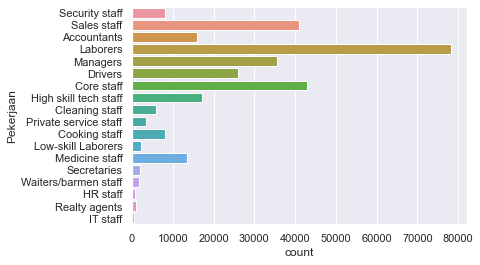

In [213]:
sns.countplot(y ='Pekerjaan', data = dataset)
plt.show()

In [214]:
filtered_pekerjaan = dataset[dataset['Pekerjaan'].isnull()]
filtered_pekerjaan

,Id_customer,JK,KepemilikanMobil,KepemilikanProperti,JmlAnak,Pendapatan,TipePendapatan,TingkatPendidikan,StatusKeluarga,TipeRumah,FlagMobile,FlagWorkPhone,FlagPhone,Email,Pekerjaan,JmlAnggotaKeluarga,Age,Experience,Overdue
0,5008804,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0,0
1,5008805,Laki-laki,Ya,Ya,0,427500.0,Bekerja,Postgraduate,Menikah,Sewa Apartemen,1,1,0,0,NaN,2.0,33.0,12.0,0
7,5008812,Perempuan,Tidak,Ya,0,283500.0,Pensioner,Postgraduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0
8,5008813,Perempuan,Tidak,Ya,0,283500.0,Pensioner,Postgraduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0
9,5008814,Perempuan,Tidak,Ya,0,283500.0,Pensioner,Postgraduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438302,6840098,Perempuan,Tidak,Ya,0,135000.0,Pensioner,Graduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0
438303,6840100,Perempuan,Tidak,Ya,0,135000.0,Pensioner,Graduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0
438304,6840102,Perempuan,Tidak,Ya,0,135000.0,Pensioner,Graduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0
438305,6840104,Laki-laki,Tidak,Ya,0,135000.0,Pensioner,Graduate,Cerai,Rumah pribadi,1,0,0,0,NaN,1.0,62.0,1001.0,0


In [215]:
filtered_pekerjaan['Experience'].value_counts()

1001.0    75288
1.0        6999
2.0        6439
3.0        5373
4.0        4709
5.0        4443
6.0        3865
7.0        3830
8.0        3541
9.0        2681
10.0       2363
0.0        1760
11.0       1692
12.0       1650
13.0       1328
15.0       1283
14.0       1070
17.0        687
16.0        606
18.0        472
19.0        471
22.0        467
21.0        455
20.0        449
27.0        238
24.0        227
23.0        226
25.0        225
28.0        215
29.0        203
26.0        169
31.0        129
32.0        104
33.0         90
34.0         67
30.0         63
40.0         42
35.0         33
43.0         33
37.0         32
41.0         30
39.0         30
36.0         24
38.0         20
42.0          8
45.0          5
Name: Experience, dtype: int64

In [216]:
filtered_pekerjaan['TipePendapatan'].value_counts()

Pensioner             75316
Bekerja               35868
Asosiasi komersial    16736
PNS                    6209
Mahasiswa/Murid           5
Name: TipePendapatan, dtype: int64

### dari analisis di atas mayoritas TipePendapatan-nya adalah Pensioner, maka kita putuskan untuk mereplace NULL value dengan 'Lain-lain'

In [217]:
dataset['Pekerjaan']=dataset['Pekerjaan'].fillna("Lain-lain")
dataset.isnull().sum()

Id_customer            0
JK                     0
KepemilikanMobil       0
KepemilikanProperti    0
JmlAnak                0
Pendapatan             0
TipePendapatan         0
TingkatPendidikan      0
StatusKeluarga         0
TipeRumah              0
FlagMobile             0
FlagWorkPhone          0
FlagPhone              0
Email                  0
Pekerjaan              0
JmlAnggotaKeluarga     0
Age                    0
Experience             0
Overdue                0
dtype: int64

### Machine Learning hanya bisa mengolah data numerik, sehingga kita harus melakukan encoding data yang bertipe kategori (object)

In [218]:
# one hot encoding categorical variables
num_col = dataset.select_dtypes(exclude = 'object')
char_col = dataset.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)

dataset_clean = pd.concat([num_col, encoded_char_col], axis=1)
dataset_clean.dtypes

Id_customer                            int64
JmlAnak                                int64
Pendapatan                           float64
FlagMobile                             int64
FlagWorkPhone                          int64
FlagPhone                              int64
Email                                  int64
JmlAnggotaKeluarga                   float64
Age                                  float64
Experience                           float64
Overdue                                int32
JK_Laki-laki                           uint8
JK_Perempuan                           uint8
KepemilikanMobil_Tidak                 uint8
KepemilikanMobil_Ya                    uint8
KepemilikanProperti_Tidak              uint8
KepemilikanProperti_Ya                 uint8
TipePendapatan_Asosiasi komersial      uint8
TipePendapatan_Bekerja                 uint8
TipePendapatan_Mahasiswa/Murid         uint8
TipePendapatan_PNS                     uint8
TipePendapatan_Pensioner               uint8
TingkatPen

In [219]:
dataset_clean

,Id_customer,JmlAnak,Pendapatan,FlagMobile,FlagWorkPhone,FlagPhone,Email,JmlAnggotaKeluarga,Age,Experience,...,Pekerjaan_Lain-lain,Pekerjaan_Low-skill Laborers,Pekerjaan_Managers,Pekerjaan_Medicine staff,Pekerjaan_Private service staff,Pekerjaan_Realty agents,Pekerjaan_Sales staff,Pekerjaan_Secretaries,Pekerjaan_Security staff,Pekerjaan_Waiters/barmen staff
0,5008804,0,427500.0,1,1,0,0,2.0,33.0,12.0,...,1,0,0,0,0,0,0,0,0,0
1,5008805,0,427500.0,1,1,0,0,2.0,33.0,12.0,...,1,0,0,0,0,0,0,0,0,0
2,5008806,0,112500.0,1,0,0,0,2.0,59.0,3.0,...,0,0,0,0,0,0,0,0,1,0
3,5008808,0,270000.0,1,0,1,1,1.0,52.0,8.0,...,0,0,0,0,0,0,1,0,0,0
4,5008809,0,270000.0,1,0,1,1,1.0,52.0,8.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438305,6840104,0,135000.0,1,0,0,0,1.0,62.0,1001.0,...,1,0,0,0,0,0,0,0,0,0
438306,6840222,0,103500.0,1,0,0,0,1.0,44.0,8.0,...,0,0,0,0,0,0,0,0,0,0
438307,6841878,0,54000.0,1,1,0,0,1.0,22.0,1.0,...,0,0,0,0,0,0,1,0,0,0
438308,6842765,0,72000.0,1,0,0,0,2.0,59.0,1001.0,...,1,0,0,0,0,0,0,0,0,0


In [194]:
num_col = dataset.select_dtypes(exclude = 'object')
char_col = dataset.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)
encoded_char_col

,JK_Laki-laki,JK_Perempuan,KepemilikanMobil_Tidak,KepemilikanMobil_Ya,KepemilikanProperti_Tidak,KepemilikanProperti_Ya,TipePendapatan_Asosiasi komersial,TipePendapatan_Bekerja,TipePendapatan_Mahasiswa/Murid,TipePendapatan_PNS,...,Pekerjaan_Lain-lain,Pekerjaan_Low-skill Laborers,Pekerjaan_Managers,Pekerjaan_Medicine staff,Pekerjaan_Private service staff,Pekerjaan_Realty agents,Pekerjaan_Sales staff,Pekerjaan_Secretaries,Pekerjaan_Security staff,Pekerjaan_Waiters/barmen staff
0,1,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438305,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
438306,0,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
438307,0,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
438308,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Lakukan data split untuk data test dan train 

In [153]:
#data split buat test dan train

data = dataset_clean
data.drop(['Id_customer'],axis = 1, inplace = True)
x = data.drop(['Overdue'], axis = 1)
y = data['Overdue']

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [155]:
model = XGBClassifier() 

model.fit(x_train, np.ravel(y_train)) # train tree

predict = model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_prob = pd.DataFrame(predict[:,1],columns = ['Overdue Probability'])
predict_prob['Overdue Probability'] = predict_prob['Overdue Probability'].astype('int')
pd.concat([predict_prob, y_test.reset_index(drop=True)],axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:52:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Overdue Probability,Overdue
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
144638,0,0
144639,0,0
144640,0,0
144641,0,0


In [156]:
print("Ada {} fitur di dataset".format(dataset_clean.shape[1]))


Ada 51 fitur di dataset


In [157]:
print("Akurasi model menggunakan data sample:")
round(model.score(x_test,y_test),3)

Akurasi model menggunakan data sample:


0.999

In [158]:
#akurasi pakai data sample sangat bagus. mari kita cek pakai data prediksi yang diberikan
#load data test
data_test = pd.read_csv(r"D:\Project\INALYST-CREDIT SCORE\dataset\data_test.csv")
data_test.head()

,Id_customer,JK,KepemilikanMobil,KepemilikanProperti,JmlAnak,Pendapatan,TipePendapatan,TingkatPendidikan,StatusKeluarga,TipeRumah,FlagMobile,FlagWorkPhone,FlagPhone,Email,Pekerjaan,JmlAnggotaKeluarga,Age,Experience
0,5142248,Perempuan,Tidak,Ya,0,225000.0,PNS,Graduate,Menikah,Rumah pribadi,1,0,0,0,Private service staff,2.0,54.0,6.0
1,5036925,Perempuan,Ya,Ya,0,157500.0,Asosiasi komersial,Graduate,Menikah,Rumah pribadi,1,1,1,1,Core staff,2.0,33.0,8.0
2,5126080,Perempuan,Tidak,Ya,1,112500.0,PNS,Graduate,Menikah,Rumah pribadi,1,0,0,0,Managers,3.0,41.0,7.0
3,5088887,Perempuan,Tidak,Ya,0,171000.0,Bekerja,Graduate,Belum Menikah,Sewa Apartemen,1,0,0,0,Laborers,1.0,46.0,2.0
4,5022156,Perempuan,Ya,Ya,2,180000.0,Asosiasi komersial,Postgraduate,Menikah,Rumah pribadi,1,0,1,1,NaN,4.0,32.0,8.0


In [159]:
#Lakukan treatment yang sama dengan data training tadi
data_test['Pekerjaan']=data_test['Pekerjaan'].fillna("Lain-lain")
data_test.isnull().sum()

Id_customer            0
JK                     0
KepemilikanMobil       0
KepemilikanProperti    0
JmlAnak                0
Pendapatan             0
TipePendapatan         0
TingkatPendidikan      0
StatusKeluarga         0
TipeRumah              0
FlagMobile             0
FlagWorkPhone          0
FlagPhone              0
Email                  0
Pekerjaan              0
JmlAnggotaKeluarga     0
Age                    0
Experience             0
dtype: int64

In [160]:
data_test.shape

(200, 18)

In [161]:
# one hot encoding categorical variables
num_col = data_test.select_dtypes(exclude = 'object')
char_col = data_test.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)

data_test_clean = pd.concat([num_col, encoded_char_col], axis=1)

data_prediksi=data_test_clean
data_prediksi=data_test_clean.drop(['Id_customer'], axis = 1)
data_prediksi.dtypes

JmlAnak                                int64
Pendapatan                           float64
FlagMobile                             int64
FlagWorkPhone                          int64
FlagPhone                              int64
Email                                  int64
JmlAnggotaKeluarga                   float64
Age                                  float64
Experience                           float64
JK_Laki-laki                           uint8
JK_Perempuan                           uint8
KepemilikanMobil_Tidak                 uint8
KepemilikanMobil_Ya                    uint8
KepemilikanProperti_Tidak              uint8
KepemilikanProperti_Ya                 uint8
TipePendapatan_Asosiasi komersial      uint8
TipePendapatan_Bekerja                 uint8
TipePendapatan_PNS                     uint8
TipePendapatan_Pensioner               uint8
TingkatPendidikan_Graduate             uint8
TingkatPendidikan_Postgraduate         uint8
TingkatPendidikan_Undergraduate        uint8
StatusKelu

In [162]:
#handler buat memastikan kolom di data training sama dengan data prediksinya
#sering kali jumlah kolomnya bisa beda ketika kolomnya kena handling one hot encoder

template=dataset_clean[dataset_clean["JmlAnak"] == 9945] #angka random yang kira2 ga mungkin diinput untuk JmlAnak

data_prediksi=pd.concat([template,data_prediksi])
data_prediksi=data_prediksi.drop(['Overdue'], axis = 1)
data_prediksi_clean=data_prediksi.fillna(0)


In [163]:
predict = model.predict_proba(data_prediksi_clean) # 1st col = pred val, 2nd col = pred prob

predict_prob = pd.DataFrame(predict[:,1],columns = ['Overdue Probability'])

#pd.concat([predict_prob, y_test.reset_index(drop=True)],axis=1)

In [164]:
predict_prob

,Overdue Probability
0,0.000140
1,0.000248
2,0.000102
3,0.000022
4,0.000158
...,...
195,0.000201
196,0.000464
197,0.000058
198,0.000071


In [165]:
result=pd.concat([data_test_clean['Id_customer'], predict_prob.reset_index(drop=True)],axis=1)

In [166]:
#Export Result to CSV
result.to_csv('result.csv',index=False)

In [167]:
df_result = pd.read_csv('result.csv')
df_result

,Id_customer,Overdue Probability
0,5142248,0.000140
1,5036925,0.000248
2,5126080,0.000102
3,5088887,0.000022
4,5022156,0.000158
...,...,...
195,5105368,0.000201
196,5116026,0.000464
197,5067627,0.000058
198,5090052,0.000071
